# Task 1: Response to Data analysis and feature engineering
使用pandas导入训练数据集，并分析特征和标签的分布情况。

In [80]:
import platform
import math
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# 导入缺失的库
from sklearn.decomposition import FastICA
import seaborn as sns
# 导入聚类相关的库
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
from sklearn.decomposition import FastICA, TruncatedSVD
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings



# 设置随机种子和中文显示
np.random.seed(42)
# 设置中文显示
system = platform.system()

if system == 'Darwin':  # Mac系统
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
elif system == 'Windows':  # Windows系统
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
elif system == 'Linux':  # Linux系统
    # Linux系统可能需要安装中文字体，例如 Noto Sans CJK SC
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK SC']
else:
    # 默认字体（如果系统未识别）
    plt.rcParams['font.sans-serif'] = ['SimHei']

# 读取数据
df = pd.read_csv("./student_data.csv")

# 初始化模型存储结构
# 在代码开头初始化完整的字典结构
grade_models = {
    'pca_model': {},
    'bayes_models': {},
    'random_forest_models': {}
}

# 系别映射（如果需要）
mapping = {1: 'A', 2: 'B', 3: 'C', 4: 'D'}
if df['Programme'].dtype == 'int64' or df['Programme'].iloc[0] in [1, 2, 3, 4]:
    df['Programme'] = df['Programme'].map(mapping)

# 数据处理和特征提取函数
def process_data(df, mode='train', preprocessors=None):
    """
    处理数据并提取特征，确保训练和测试数据使用相同的预处理

    参数:
    df - 输入数据框
    mode - 'train'或'test'
    preprocessors - 训练模式下创建并返回，测试模式下使用

    返回:
    feature_sets - 特征集字典
    preprocessors - 预处理器字典(仅训练模式)
    """
    # 去除索引列（如果存在）
    if 'Index' in df.columns:
        df = df.drop('Index', axis=1)

    print(f"{mode}数据集形状: {df.shape}")
    print(f"\n{mode}数据集前5行:")
    print(df.head())

    # 只保留数值特征
    numeric_df = df.select_dtypes(include=['float64', 'int64'])

    feature_sets = {}

    if mode == 'train':
        preprocessors = {'scalers': {}}

    # 特征集1：考试分数
    if any('Q' in col for col in numeric_df.columns):
        exam_cols = [col for col in numeric_df.columns if 'Q' in col]
        if mode == 'train':
            preprocessors['exam_cols'] = exam_cols
    else:
        if mode == 'train':
            # 使用最后5列
            exam_cols = numeric_df.columns[-5:].tolist()
            preprocessors['exam_cols'] = exam_cols
        else:
            # 测试模式使用保存的列名
            exam_cols = preprocessors['exam_cols']

    # 确保测试数据有相同的列
    available_exam_cols = [col for col in exam_cols if col in numeric_df.columns]
    if len(available_exam_cols) != len(exam_cols):
        print(f"警告: 测试数据缺少一些考试分数列，使用可用的{len(available_exam_cols)}列")

    feature_sets['考试分数'] = numeric_df[available_exam_cols].values

    # 特征集2：学生基本信息，去除年级
    basic_patterns = ['性别', 'Gender', 'sex', '项目', 'Total', '总分', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5']
    if mode == 'train':
        basic_cols = []
        for pat in basic_patterns:
            basic_cols += [col for col in numeric_df.columns if pat.lower() in col.lower()]
        basic_cols = list(dict.fromkeys(basic_cols))  # 去重
        preprocessors['basic_cols'] = basic_cols

        if not basic_cols:
            basic_cols = numeric_df.columns[:2].tolist()
            preprocessors['basic_cols'] = basic_cols
    else:
        # 测试模式使用保存的列名
        basic_cols = preprocessors['basic_cols']

    # 确保测试数据有相同的列
    available_basic_cols = [col for col in basic_cols if col in numeric_df.columns]
    feature_sets['去除年级'] = numeric_df[available_basic_cols].values

    # 特征集3：全部特征（排除programme列）
    if mode == 'train':
        programme_cols = [col for col in numeric_df.columns if 'programme' in col.lower() or 'program' in col.lower()]
        preprocessors['programme_cols'] = programme_cols
    else:
        programme_cols = preprocessors['programme_cols']

    if programme_cols:
        exclude_cols = [col for col in programme_cols if col in numeric_df.columns]
        feature_sets['全部特征'] = numeric_df.drop(columns=exclude_cols).values
    else:
        feature_sets['全部特征'] = numeric_df.values

    # 标准化处理
    for name, data in feature_sets.items():
        if mode == 'train':
            # 训练模式：创建并拟合标准化器
            scaler = StandardScaler()
            feature_sets[name] = scaler.fit_transform(data)
            preprocessors['scalers'][name] = scaler
        else:
            # 测试模式：使用已拟合的标准化器
            if name in preprocessors['scalers']:
                feature_sets[name] = preprocessors['scalers'][name].transform(data)
            else:
                print(f"错误: 没有找到特征集{name}的预处理器")

    if mode == 'train':
        return feature_sets, preprocessors
    else:
        return feature_sets

# 训练阶段


# 测试阶段(示例) - 预测时使用
# test_feature_sets = process_data(test_df, mode='test', preprocessors=preprocessors)


导入数据后，查看数据集的基本信息。处理数据缺失
## 特征转换
应用三种不同的数据转换方法：标准化缩放、PCA降维和独立成分分析(ICA)

In [81]:

# 去除索引列（如果存在）
if 'Index' in df.columns:
    df = df.drop('Index', axis=1)

print(f"数据集形状: {df.shape}")
print("\n数据集前5行:")
display(df.head())
print("\n数据集信息:")
display(df.info())
print(f"\n缺失值情况:")
display(df.isnull().sum())

# 只保留数值特征
numeric_df = df.select_dtypes(include=['float64', 'int64'])
feature_sets, preprocessors = process_data(df, mode='train')

print("创建的特征集:")
for name, features in feature_sets.items():
    print(f"- {name}: 形状 {features.shape}")

# 检查特征集并标准化
for name, data in feature_sets.items():
    print(f"\n特征集: {name}")
    print(f"数据集形状: {data.shape}")
    print("前5行:")
    print(pd.DataFrame(data[:5]))
    # 标准化
    scaler = StandardScaler()
    feature_sets[name] = scaler.fit_transform(data)
print("\n数据集统计描述:")
display(df.describe())

数据集形状: (466, 9)

数据集前5行:


Gender  Grade  Q1  Q2  Q3    Q4  Q5 Programme  Total
0       1      3   8   4   2  10.0   0         C   24.0
1       2      3   4   2   8   8.0   0         C   22.0
2       2      3   4   0   0   0.0   2         A    6.0
3       1      3   0   2   4   0.0   0         B    6.0
4       2      2   8   8   6   8.0   3         A   33.0


数据集信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Gender     466 non-null    int64  
 1   Grade      466 non-null    int64  
 2   Q1         466 non-null    int64  
 3   Q2         466 non-null    int64  
 4   Q3         466 non-null    int64  
 5   Q4         466 non-null    float64
 6   Q5         466 non-null    int64  
 7   Programme  466 non-null    object 
 8   Total      466 non-null    float64
dtypes: float64(2), int64(6), object(1)
memory usage: 32.9+ KB


None


缺失值情况:


Gender       0
Grade        0
Q1           0
Q2           0
Q3           0
Q4           0
Q5           0
Programme    0
Total        0
dtype: int64

train数据集形状: (466, 9)

train数据集前5行:
   Gender  Grade  Q1  Q2  Q3    Q4  Q5 Programme  Total
0       1      3   8   4   2  10.0   0         C   24.0
1       2      3   4   2   8   8.0   0         C   22.0
2       2      3   4   0   0   0.0   2         A    6.0
3       1      3   0   2   4   0.0   0         B    6.0
4       2      2   8   8   6   8.0   3         A   33.0
创建的特征集:
- 考试分数: 形状 (466, 5)
- 去除年级: 形状 (466, 7)
- 全部特征: 形状 (466, 8)

特征集: 考试分数
数据集形状: (466, 5)
前5行:
          0         1         2         3         4
0  0.622612  0.068991 -2.121240  1.149385 -0.817506
1 -1.199285 -0.755364 -0.665068  0.603398 -0.817506
2 -1.199285 -1.579720 -2.606630 -1.580551  0.552846
3 -3.021182 -0.755364 -1.635849 -1.580551 -0.817506
4  0.622612  1.717702 -1.150459  0.603398  1.238021

特征集: 去除年级
数据集形状: (466, 7)
前5行:
          0         1         2         3         4         5         6
0 -1.338065 -0.432838  0.622612  0.068991 -2.121240  1.149385 -0.817506
1  0.747348 -0.639500 -1.199285 -0.755364

Gender       Grade          Q1          Q2          Q3          Q4  \
count  466.000000  466.000000  466.000000  466.000000  466.000000  466.000000   
mean     1.641631    2.062232    6.633047    3.832618   10.740343    5.789700   
std      0.480037    0.241836    2.197873    2.428746    4.124822    3.667026   
min      1.000000    2.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    2.000000    6.000000    2.000000    8.000000    2.000000   
50%      2.000000    2.000000    8.000000    4.000000   12.000000    7.000000   
75%      2.000000    2.000000    8.000000    6.000000   14.000000    9.000000   
max      2.000000    3.000000    8.000000    8.000000   14.000000   10.000000   

               Q5       Total  
count  466.000000  466.000000  
mean     1.193133   28.188841  
std      1.461048    9.688024  
min      0.000000    0.000000  
25%      0.000000   22.000000  
50%      1.000000   30.000000  
75%      2.000000   36.000000  
max      6.000000   46.000000

## 特征转换
应用三种不同的数据转换方法：标准化缩放、PCA降维和独立成分分析(ICA)

考试分数 已完成标准化转换
考试分数 PCA解释方差比: [0.46949456 0.16067865 0.14823782 0.12260938 0.09897959]
考试分数 PCA累计方差占比: 1.0000
考试分数 已完成ICA转换
去除年级 已完成标准化转换
去除年级 PCA解释方差比: [0.4751933  0.1519247  0.11275677 0.10206173 0.08740683 0.07065668
 0.        ]
去除年级 PCA累计方差占比: 1.0000
去除年级 已完成ICA转换
全部特征 已完成标准化转换
全部特征 PCA解释方差比: [0.41579904 0.1470437  0.12281459 0.09391524 0.08339353 0.07606106
 0.06097284 0.        ]
全部特征 PCA累计方差占比: 1.0000
全部特征 已完成ICA转换


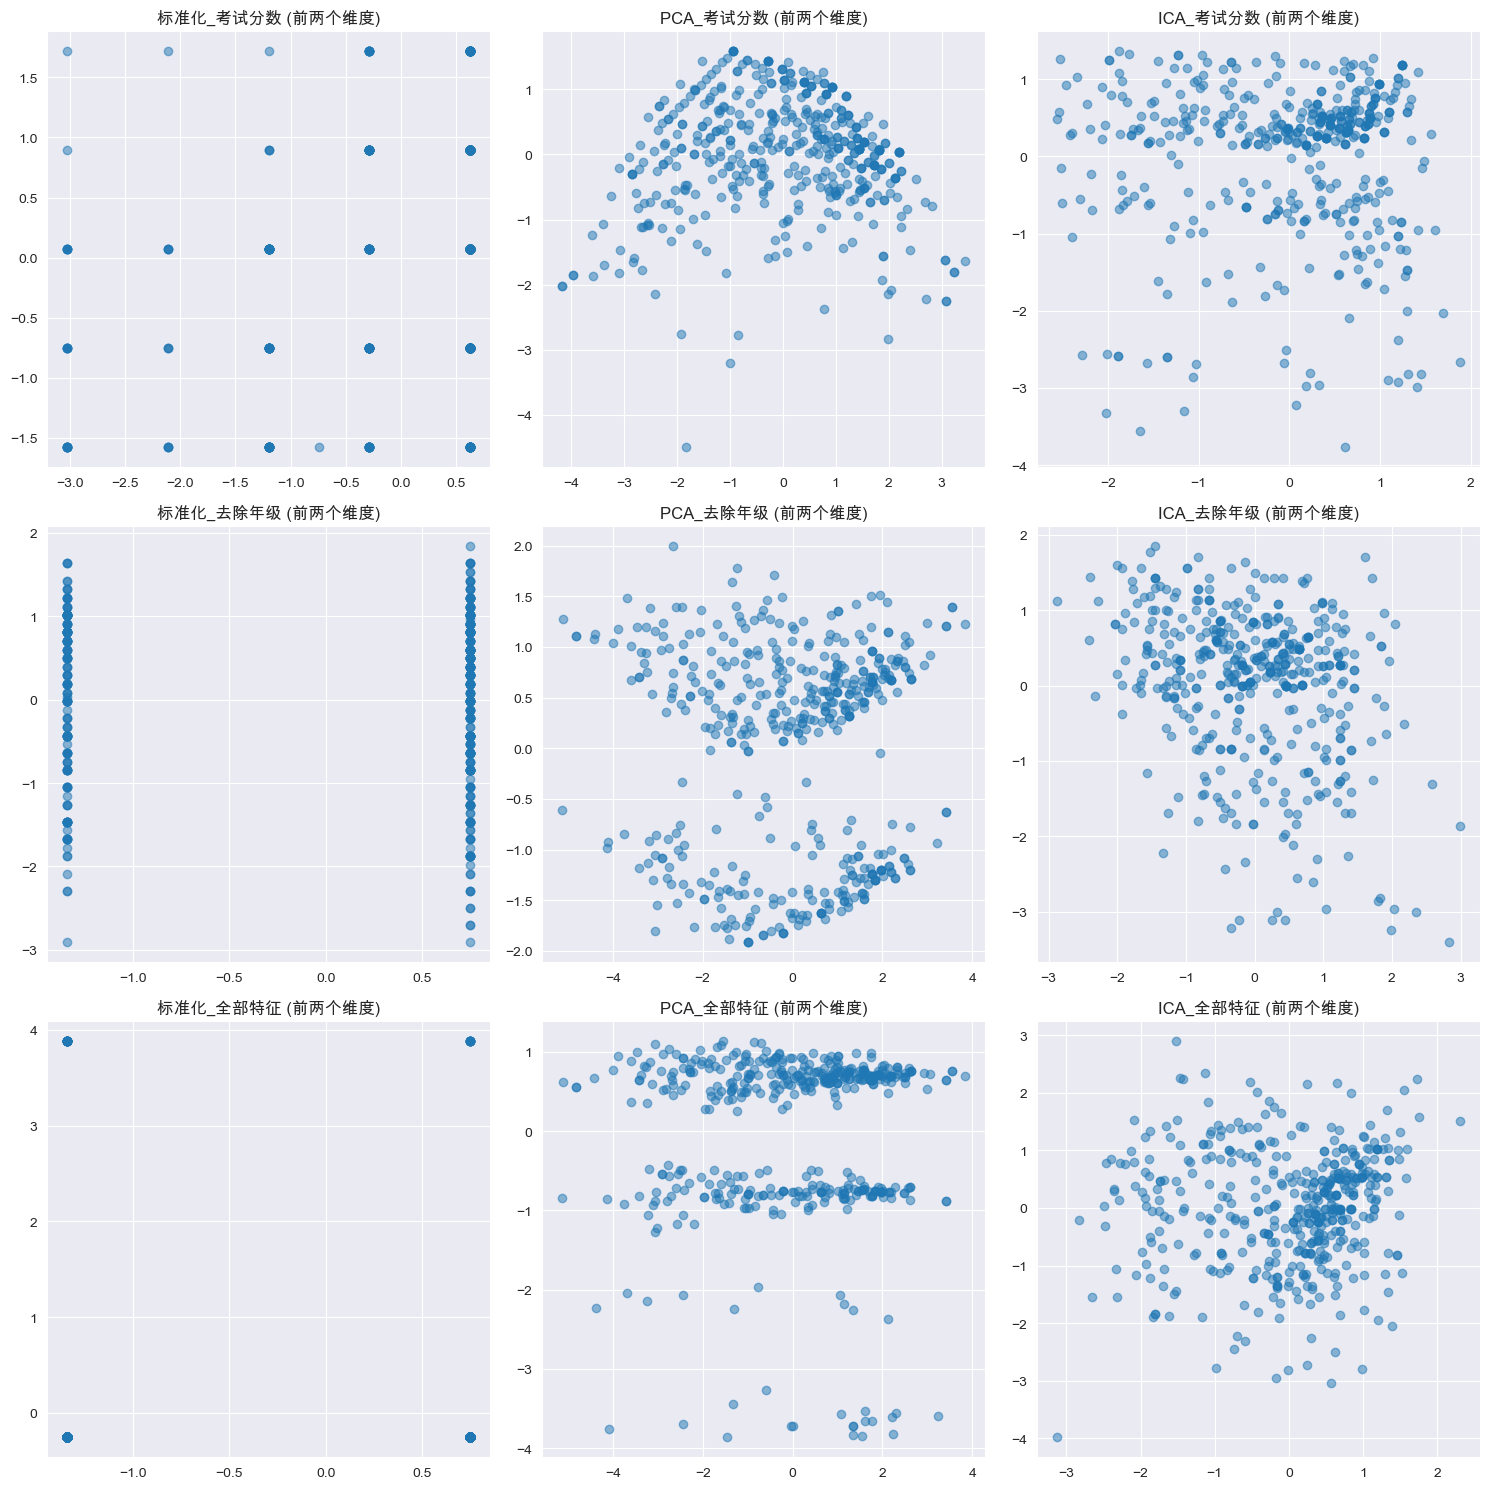

In [82]:


feature_set = feature_sets
feature_sets = {}
for name, X in feature_set.items():
    # 转换1: 标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    feature_sets['标准化_' + name] = X_scaled
    print(f"{name} 已完成标准化转换")

    # 转换2: PCA降维
    pca = PCA(n_components=min(X.shape[1], 10))
    X_pca = pca.fit_transform(X_scaled)
    feature_sets['PCA_' + name] = X_pca
    print(f"{name} PCA解释方差比: {pca.explained_variance_ratio_}")
    print(f"{name} PCA累计方差占比: {np.sum(pca.explained_variance_ratio_):.4f}")

    # 转换3: FastICA
    ica = FastICA(n_components=min(X.shape[1], 10), random_state=42)
    X_ica = ica.fit_transform(X_scaled)
    feature_sets['ICA_' + name] = X_ica
    print(f"{name} 已完成ICA转换")

# 可视化所有特征集
n = len(feature_sets)
cols = 3
rows = math.ceil(n / cols)
plt.figure(figsize=(5 * cols, 5 * rows))
for i, (fname, data) in enumerate(feature_sets.items()):
    plt.subplot(rows, cols, i + 1)
    if data.shape[1] > 1:
        plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
        plt.title(f"{fname} (前两个维度)")
    else:
        plt.hist(data[:, 0], bins=20)
        plt.title(f"{fname}分布")
plt.tight_layout()
plt.show()

## 聚类评估函数
定义用于评估聚类结果的性能指标函数

In [83]:
# 第四个代码单元格 - 评估函数
def evaluate_clustering(X, labels, name):
    """计算聚类性能指标"""
    try:
        silhouette = silhouette_score(X, labels)
    except:
        silhouette = -1

    try:
        db_score = davies_bouldin_score(X, labels)
    except:
        db_score = float('inf')

    try:
        ch_score = calinski_harabasz_score(X, labels)
    except:
        ch_score = -1

    return {
        'silhouette_score': silhouette,  # 越高越好
        'davies_bouldin_score': db_score,  # 越低越好
        'calinski_harabasz_score': ch_score,  # 越高越好
        'method': name
    }

## 聚类算法实现
实现三种聚类算法及其不同参数设置：
1. K-means聚类
2. 高斯混合模型(GMM)
3. 层次聚类(Hierarchical Clustering)

In [84]:
# 第五个代码单元格 - K-means聚类
def run_kmeans(X, n_clusters_range=[4], init_methods=['k-means++', 'random']):
    """运行K-means并尝试不同参数"""
    results = []

    for n_clusters in n_clusters_range:
        for init in init_methods:
            name = f"KMeans(n_clusters={n_clusters}, init={init})"
            try:
                model = KMeans(n_clusters=n_clusters, init=init, random_state=42)
                labels = model.fit_predict(X)

                # 评估结果
                result = evaluate_clustering(X, labels, name)
                result['labels'] = labels
                result['model'] = model
                result['n_clusters'] = n_clusters
                result['init'] = init

                results.append(result)
                print(f"完成: {name}")
            except Exception as e:
                print(f"错误 {name}: {str(e)}")

    return results

In [85]:
# 第六个代码单元格 - 高斯混合模型
def run_gmm(X, n_components_range=[2, 3, 4, 5, 6, 7, 8], covariance_types=['full', 'tied', 'diag', 'spherical']):
    """运行高斯混合模型并尝试不同参数"""
    results = []

    for n_components in n_components_range:
        for cov_type in covariance_types:
            name = f"GMM(n_components={n_components}, covariance_type={cov_type})"
            try:
                model = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
                labels = model.fit_predict(X)

                # 评估结果
                result = evaluate_clustering(X, labels, name)
                result['labels'] = labels
                result['model'] = model
                result['n_components'] = n_components
                result['covariance_type'] = cov_type

                results.append(result)
                print(f"完成: {name}")
            except Exception as e:
                print(f"错误 {name}: {str(e)}")

    return results

In [86]:
# 第七个代码单元格 - 层次聚类
def run_hierarchical(X, n_clusters_range=[4], linkage_methods=['ward', 'complete', 'average', 'single']):
    """运行层次聚类并尝试不同参数"""
    results = []

    for n_clusters in n_clusters_range:
        for linkage in linkage_methods:
            # ward只能用于欧氏距离
            if linkage == 'ward':
                affinity = 'euclidean'
            else:
                affinity = 'euclidean'  # 也可以尝试其他距离

            name = f"HC(n_clusters={n_clusters}, linkage={linkage})"
            try:
                model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity)
                labels = model.fit_predict(X)

                # 评估结果
                result = evaluate_clustering(X, labels, name)
                result['labels'] = labels
                result['model'] = model
                result['n_clusters'] = n_clusters
                result['linkage'] = linkage

                results.append(result)
                print(f"完成: {name}")
            except Exception as e:
                print(f"错误 {name}: {str(e)}")

    return results

## 运行聚类实验
对每种特征集运行三种聚类算法，并尝试不同的参数设置

In [87]:
# 第八个代码单元格 - 运行所有实验
# 为了限制运行时间，可以减少参数组合
n_clusters_range = [4]  # 聚类数量范围
init_methods =['k-means++']  # K-means初始化方法
covariance_types = ['full', 'tied']  # GMM协方差类型
linkage_methods = ['ward', 'complete']  # 层次聚类链接方法

# 4. 运行所有实验并收集结果
all_results = {}

for feature_name, X_transformed in feature_sets.items():
    print(f"\n处理特征集: {feature_name}")

    # 运行三种聚类算法
    kmeans_results = run_kmeans(X_transformed, n_clusters_range, init_methods)
    gmm_results = run_gmm(X_transformed, n_clusters_range, covariance_types)
    hc_results = run_hierarchical(X_transformed, n_clusters_range, linkage_methods)

    # 保存结果
    all_results[feature_name] = {
        'kmeans': kmeans_results,
        'gmm': gmm_results,
        'hierarchical': hc_results
    }


处理特征集: 标准化_考试分数
完成: KMeans(n_clusters=4, init=k-means++)
完成: GMM(n_components=4, covariance_type=full)
完成: GMM(n_components=4, covariance_type=tied)
错误 HC(n_clusters=4, linkage=ward): AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'
错误 HC(n_clusters=4, linkage=complete): AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

处理特征集: PCA_考试分数
完成: KMeans(n_clusters=4, init=k-means++)
完成: GMM(n_components=4, covariance_type=full)
完成: GMM(n_components=4, covariance_type=tied)
错误 HC(n_clusters=4, linkage=ward): AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'
错误 HC(n_clusters=4, linkage=complete): AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

处理特征集: ICA_考试分数
完成: KMeans(n_clusters=4, init=k-means++)
完成: GMM(n_components=4, covariance_type=full)
完成: GMM(n_components=4, covariance_type=tied)
错误 HC(n_clusters=4, linkage=ward): AgglomerativeClustering.__init__() got an u

## 结果分析
找出每种特征集和每种聚类方法的最佳结果

In [88]:
# 第九个代码单元格 - 找出最佳结果
# 5. 找出每种特征集和每种聚类方法的最佳结果
best_results = {}

for feature_name, methods in all_results.items():
    best_results[feature_name] = {}

    for method_name, results in methods.items():
        if method_name in ['kmeans', 'gmm', 'hierarchical']:
            # 按silhouette_score排序（越高越好）
            sorted_results = sorted(results, key=lambda x: x['silhouette_score'], reverse=True)
            if sorted_results:
                best_results[feature_name][method_name] = sorted_results[0]

In [89]:
# 第十个代码单元格 - 创建结果表格
# 6. 创建结果表格
results_table = []

for feature_name, methods in best_results.items():
    for method_name, result in methods.items():
        row = {
            '特征集': feature_name,
            '聚类方法': method_name,
            '轮廓系数': result['silhouette_score'],
            'Davies-Bouldin': result['davies_bouldin_score'],
            'Calinski-Harabasz': result['calinski_harabasz_score']
        }

        # 添加模型特有的参数
        if method_name == 'kmeans':
            row['聚类数'] = result['n_clusters']
            row['初始化方法'] = result['init']
        elif method_name == 'gmm':
            row['聚类数/组件数'] = result['n_components']
            row['协方差类型'] = result['covariance_type']
        elif method_name == 'hierarchical':
            row['聚类数'] = result['n_clusters']
            row['链接方法'] = result['linkage']

        results_table.append(row)

# 7. 将结果转换为DataFrame并显示
results_df = pd.DataFrame(results_table)
print("\n聚类结果表:")
display(results_df)


聚类结果表:


特征集    聚类方法      轮廓系数  Davies-Bouldin  Calinski-Harabasz  聚类数  \
0   标准化_考试分数  kmeans  0.214335        1.495754         162.311073  4.0   
1   标准化_考试分数     gmm  0.226803        1.330118         116.583988  NaN   
2   PCA_考试分数  kmeans  0.214335        1.495754         162.311073  4.0   
3   PCA_考试分数     gmm  0.226803        1.330118         116.583988  NaN   
4   ICA_考试分数  kmeans  0.196993        1.536039          92.468940  4.0   
5   ICA_考试分数     gmm  0.208816        1.504724          82.200266  NaN   
6   标准化_去除年级  kmeans  0.217707        1.732314         142.907579  4.0   
7   标准化_去除年级     gmm  0.178135        1.908969          84.510548  NaN   
8   PCA_去除年级  kmeans  0.217707        1.732314         142.907579  4.0   
9   PCA_去除年级     gmm  0.178135        1.908969          84.510548  NaN   
10  ICA_去除年级  kmeans  0.187045        1.579265         113.563923  4.0   
11  ICA_去除年级     gmm  0.131743        2.094850          38.625473  NaN   
12  标准化_全部特征  kmeans  0.195225        1.762221         121.742729  4.0   
13  标准化_全部特征     gmm  0.197707        1.632124          58.720106  NaN   
14  PCA_全部特征  kmeans  0.195225        1.762221         121.742729  4.0   
15  PCA_全部特征     gmm  0.197707        1.632124          58.720106  NaN   
16  ICA_全部特征  kmeans  0.189028        1.705926          83.356739  4.0   
17  ICA_全部特征     gmm  0.155467        1.734089          65.452484  NaN   

        初始化方法  聚类数/组件数 协方差类型  
0   k-means++      NaN   NaN  
1         NaN      4.0  tied  
2   k-means++      NaN   NaN  
3         NaN      4.0  tied  
4   k-means++      NaN   NaN  
5         NaN      4.0  tied  
6   k-means++      NaN   NaN  
7         NaN      4.0  tied  
8   k-means++      NaN   NaN  
9         NaN      4.0  tied  
10  k-means++      NaN   NaN  
11        NaN      4.0  full  
12  k-means++      NaN   NaN  
13        NaN      4.0  full  
14  k-means++      NaN   NaN  
15        NaN      4.0  full  
16  k-means++      NaN   NaN  
17        NaN      4.0  tied

## 可视化聚类结果
可视化展示每种特征集和聚类方法的最佳聚类结果

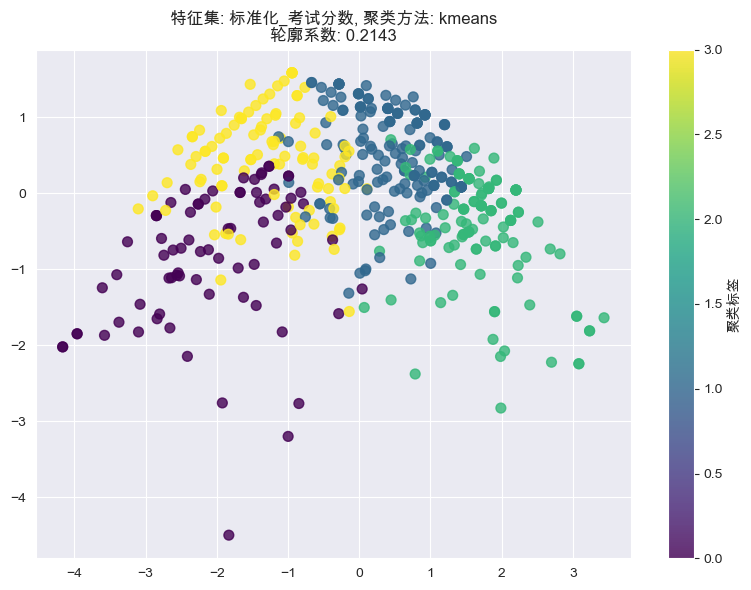

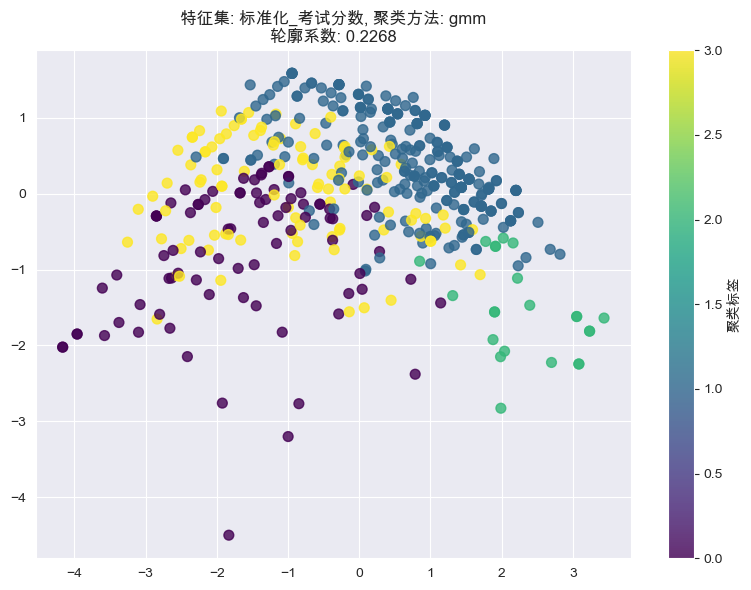

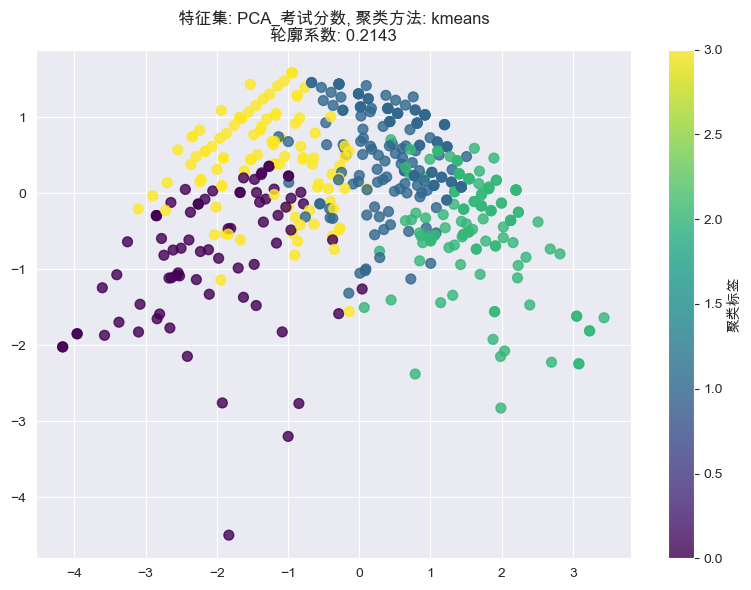

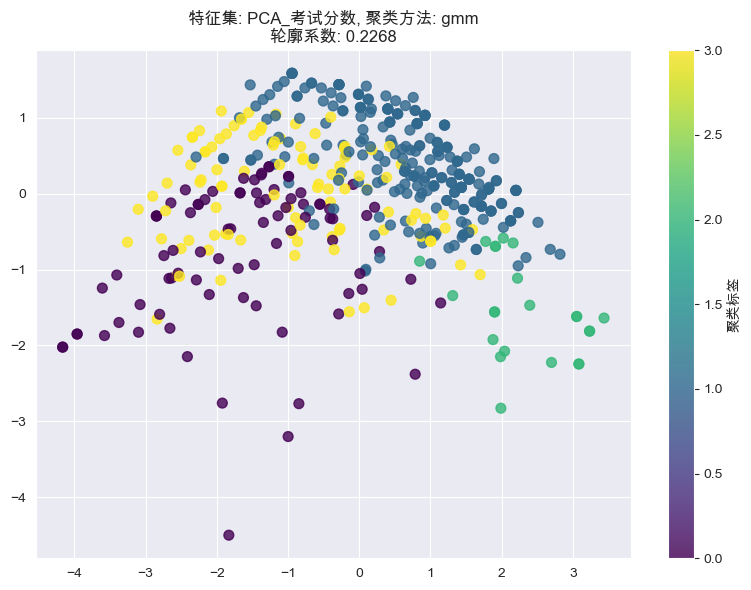

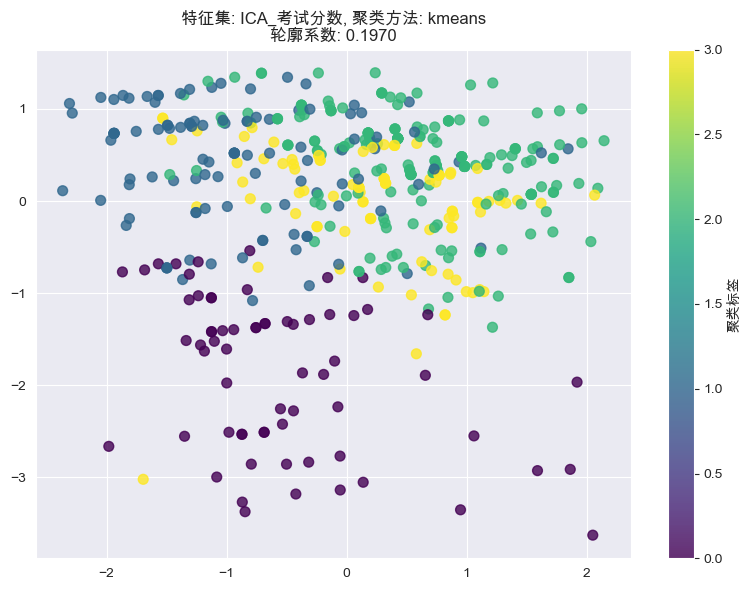

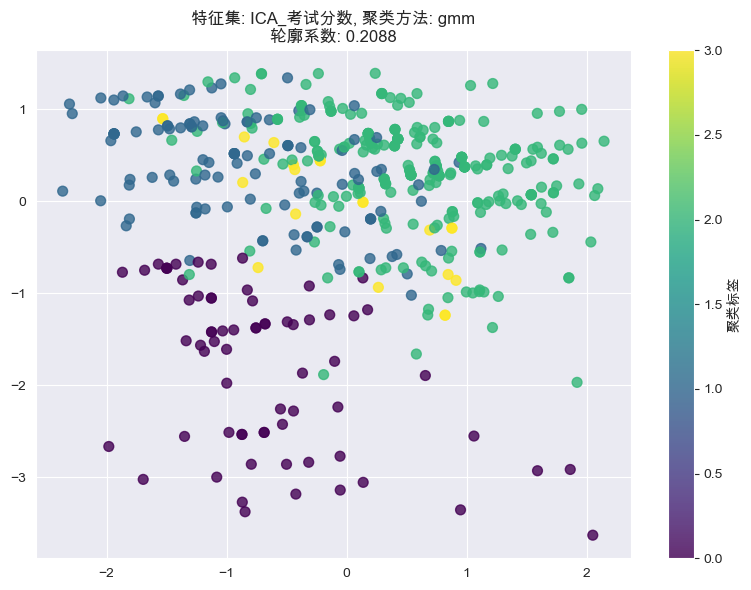

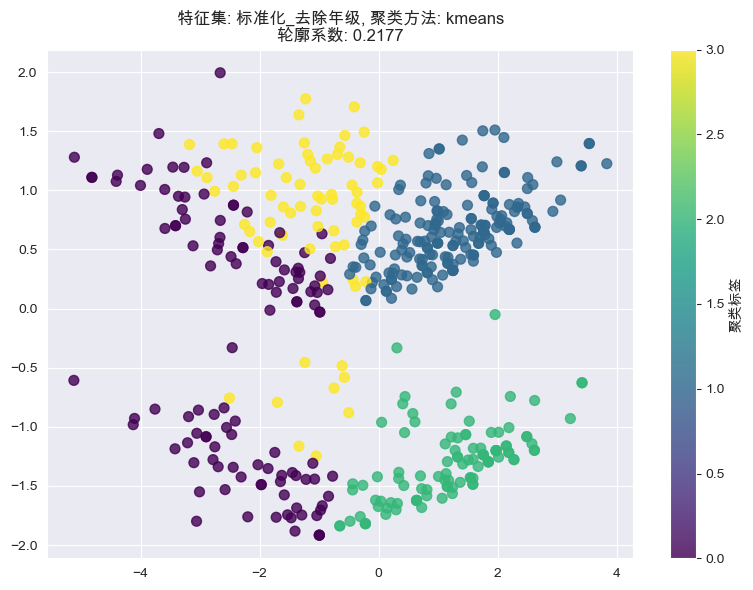

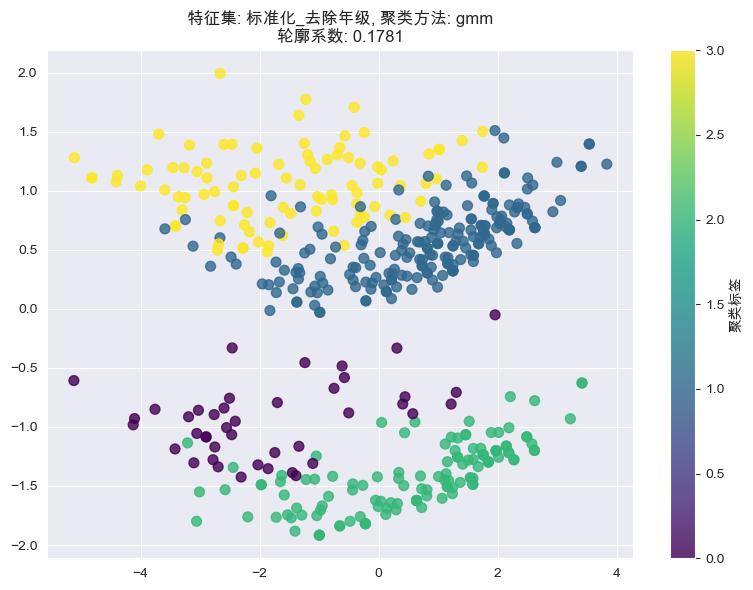

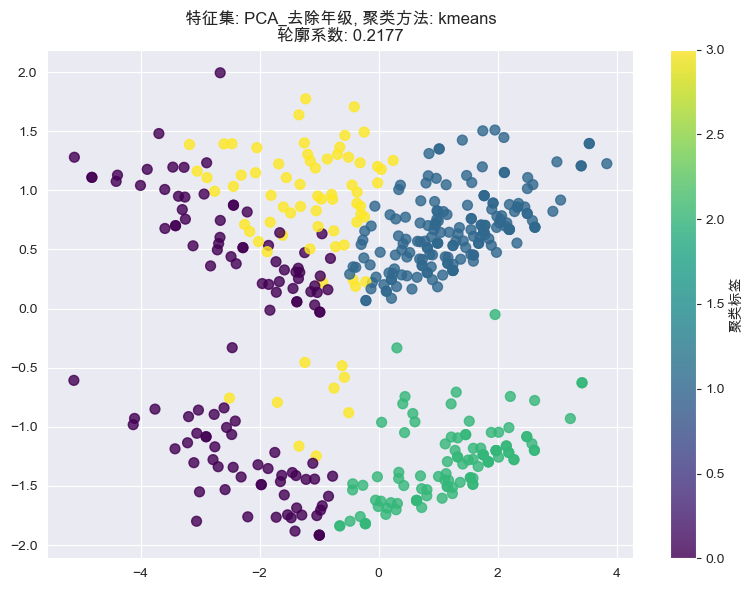

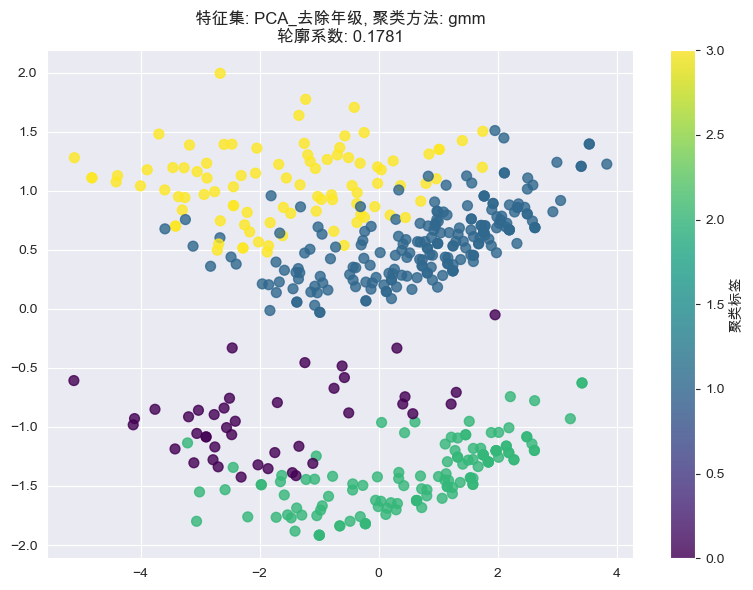

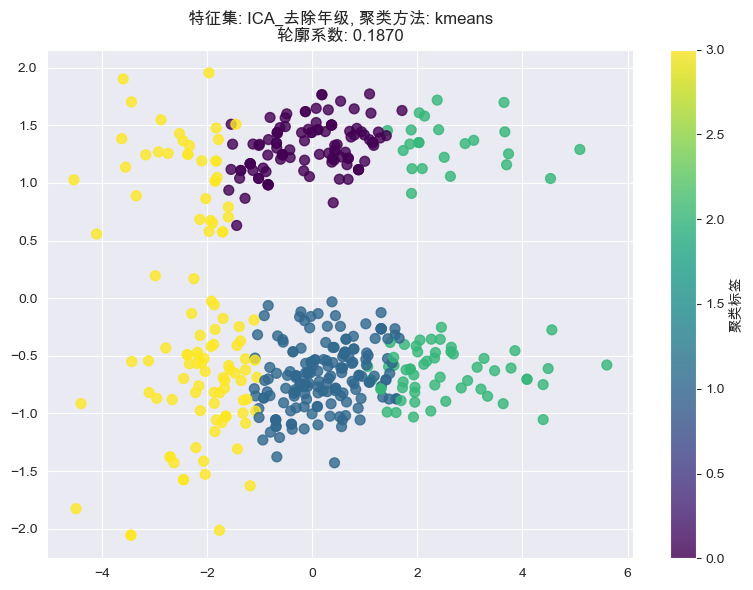

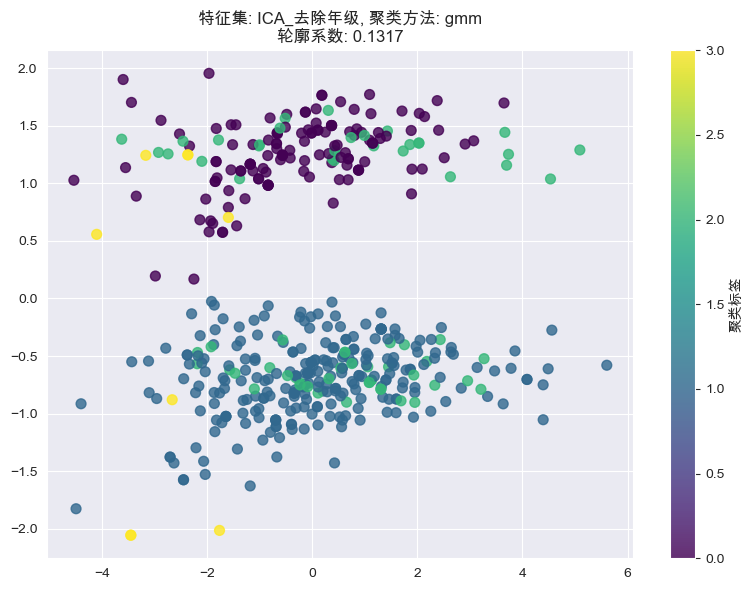

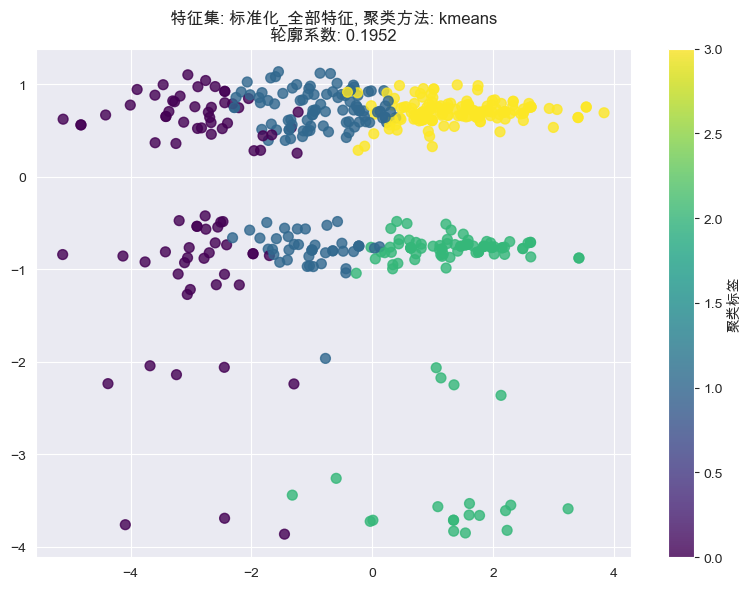

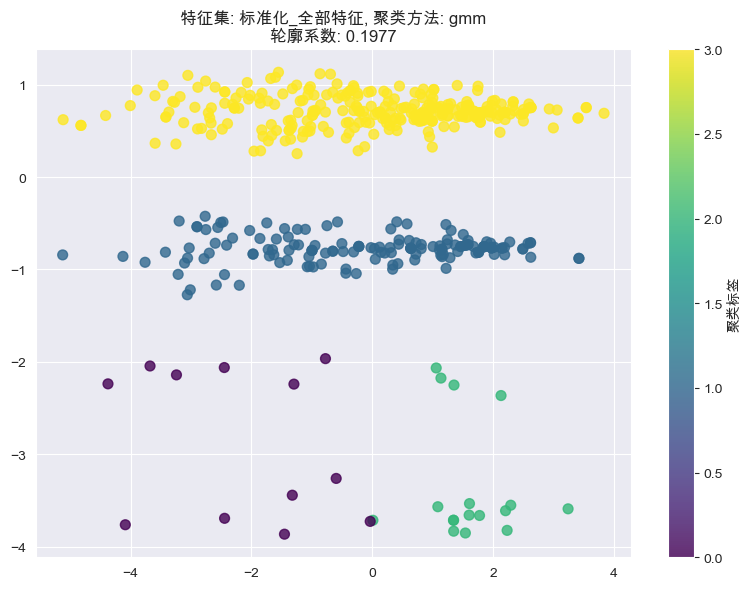

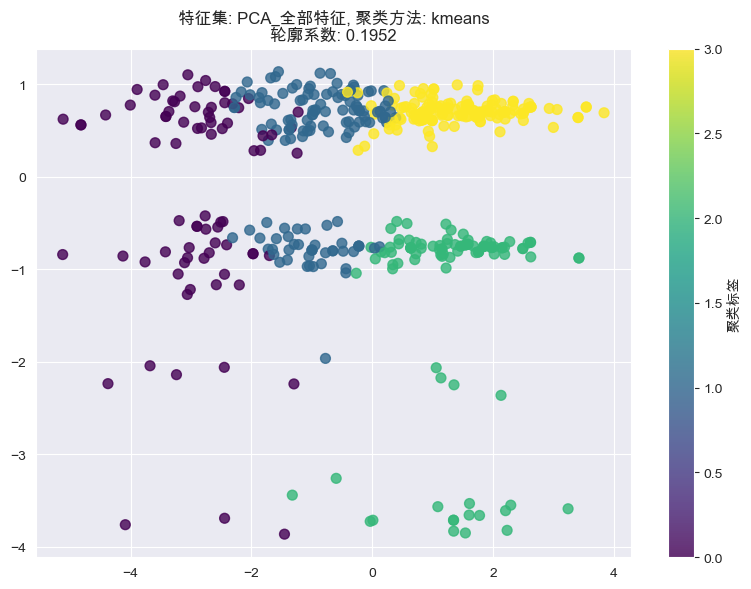

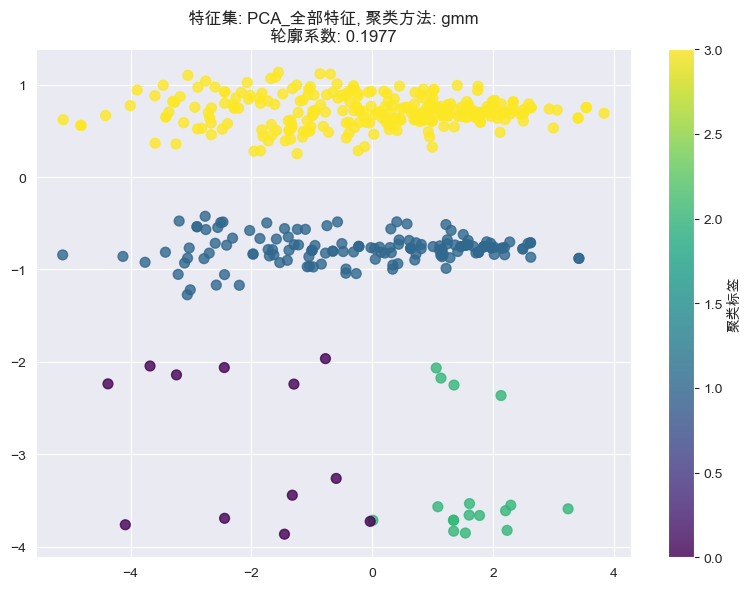

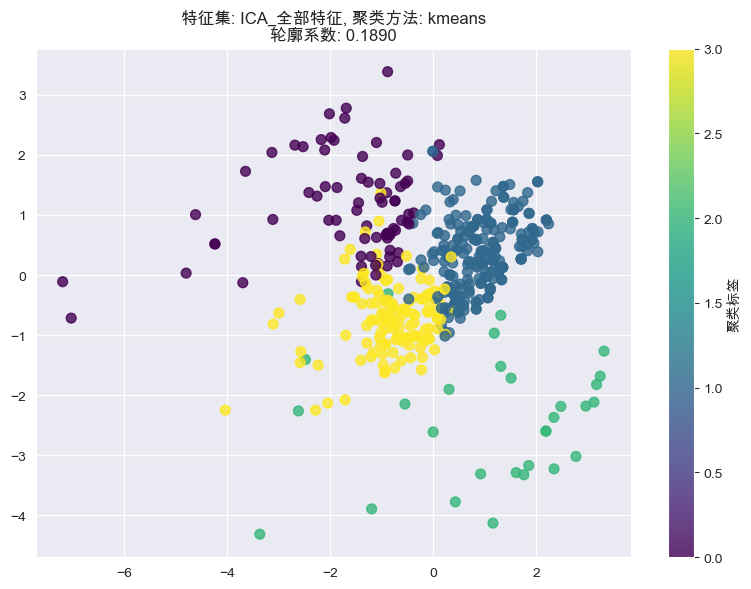

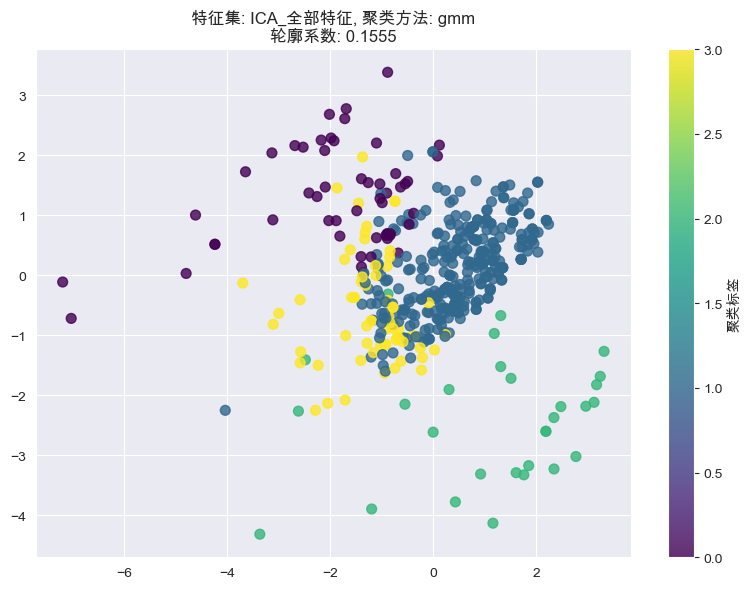

In [90]:
# 第十一个代码单元格 - 可视化最佳结果
# 8. 可视化每种特征集和聚类方法的最佳结果
for feature_name, methods in best_results.items():
    for method_name, result in methods.items():
        # 如果特征维度大于2，使用PCA降至2维进行可视化
        if feature_sets[feature_name].shape[1] > 2:
            vis_pca = PCA(n_components=2)
            X_vis = vis_pca.fit_transform(feature_sets[feature_name])
        else:
            X_vis = feature_sets[feature_name]

        plt.figure(figsize=(8, 6))
        plt.scatter(X_vis[:, 0], X_vis[:, 1], c=result['labels'], cmap='viridis', alpha=0.8, s=50)
        plt.title(f'特征集: {feature_name}, 聚类方法: {method_name}\n轮廓系数: {result["silhouette_score"]:.4f}')
        plt.colorbar(label='聚类标签')
        plt.tight_layout()
        plt.show()

最佳聚类结果汇总表:


特征集    聚类方法      轮廓系数  Davies-Bouldin  Calinski-Harabasz  聚类数  \
0   ICA_全部特征     gmm  0.155467        1.734089          65.452484  NaN   
1   ICA_全部特征  kmeans  0.189028        1.705926          83.356739  4.0   
2   ICA_去除年级     gmm  0.131743        2.094850          38.625473  NaN   
3   ICA_去除年级  kmeans  0.187045        1.579265         113.563923  4.0   
4   ICA_考试分数     gmm  0.208816        1.504724          82.200266  NaN   
5   ICA_考试分数  kmeans  0.196993        1.536039          92.468940  4.0   
6   PCA_全部特征     gmm  0.197707        1.632124          58.720106  NaN   
7   PCA_全部特征  kmeans  0.195225        1.762221         121.742729  4.0   
8   PCA_去除年级     gmm  0.178135        1.908969          84.510548  NaN   
9   PCA_去除年级  kmeans  0.217707        1.732314         142.907579  4.0   
10  PCA_考试分数     gmm  0.226803        1.330118         116.583988  NaN   
11  PCA_考试分数  kmeans  0.214335        1.495754         162.311073  4.0   
12  标准化_全部特征     gmm  0.197707        1.632124          58.720106  NaN   
13  标准化_全部特征  kmeans  0.195225        1.762221         121.742729  4.0   
14  标准化_去除年级     gmm  0.178135        1.908969          84.510548  NaN   
15  标准化_去除年级  kmeans  0.217707        1.732314         142.907579  4.0   
16  标准化_考试分数     gmm  0.226803        1.330118         116.583988  NaN   
17  标准化_考试分数  kmeans  0.214335        1.495754         162.311073  4.0   

        初始化方法  聚类数/组件数 协方差类型  
0        None      4.0  tied  
1   k-means++      NaN  None  
2        None      4.0  full  
3   k-means++      NaN  None  
4        None      4.0  tied  
5   k-means++      NaN  None  
6        None      4.0  full  
7   k-means++      NaN  None  
8        None      4.0  tied  
9   k-means++      NaN  None  
10       None      4.0  tied  
11  k-means++      NaN  None  
12       None      4.0  full  
13  k-means++      NaN  None  
14       None      4.0  tied  
15  k-means++      NaN  None  
16       None      4.0  tied  
17  k-means++      NaN  None

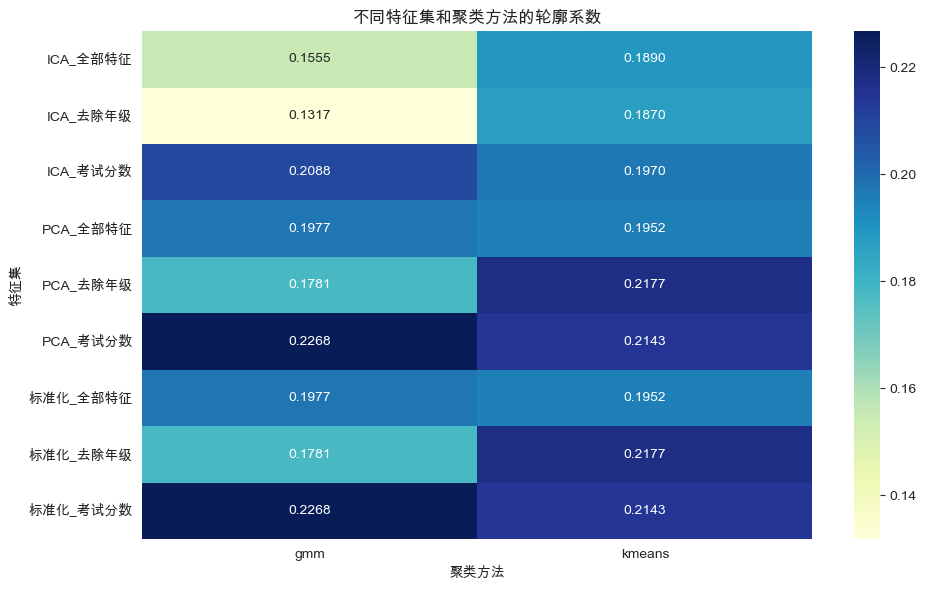

In [91]:
# 第十二个代码单元格 - 汇总表格
# 9. 生成最佳结果的汇总表格
summary_df = pd.DataFrame(results_table)

# 按特征集和聚类方法分组，找出每种组合的最佳结果
best_by_feature = summary_df.sort_values('轮廓系数', ascending=False).groupby(['特征集', '聚类方法']).first().reset_index()

print("最佳聚类结果汇总表:")
display(best_by_feature)

# 创建热力图显示不同特征集和聚类方法的轮廓系数
pivot_table = best_by_feature.pivot(index='特征集', columns='聚类方法', values='轮廓系数')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.4f')
plt.title('不同特征集和聚类方法的轮廓系数')
plt.tight_layout()
plt.show()

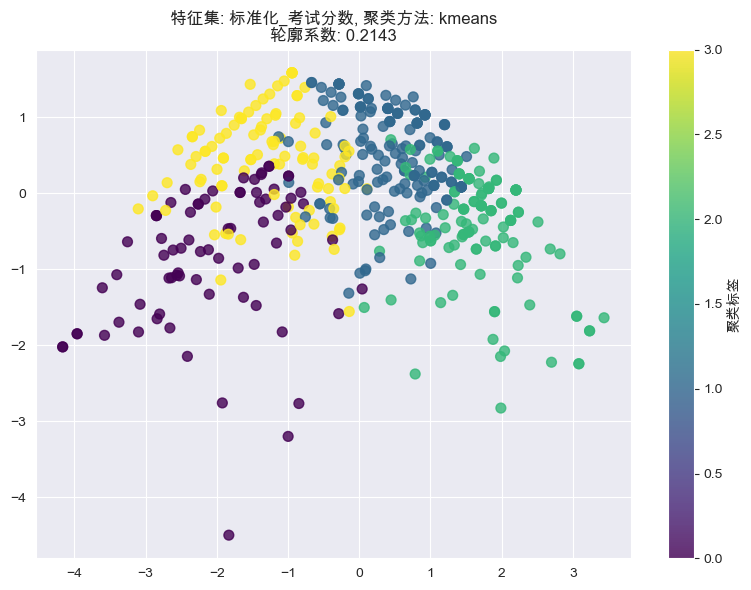


特征集: 标准化_考试分数, 聚类方法: kmeans
调整兰德指数(ARI): 0.0782
归一化互信息(NMI): 0.0822
混淆矩阵:
[[ 9 70 88 22]
 [23 28  9 28]
 [ 5 10  8  3]
 [39 53 23 48]]


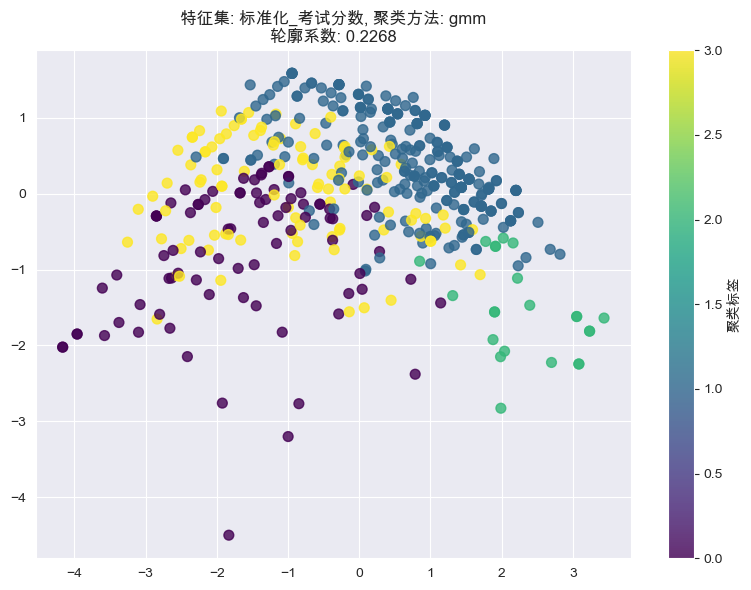


特征集: 标准化_考试分数, 聚类方法: gmm
调整兰德指数(ARI): 0.0791
归一化互信息(NMI): 0.0578
混淆矩阵:
[[ 12 139  13  25]
 [ 22  38   3  25]
 [  7  13   3   3]
 [ 42  72   4  45]]


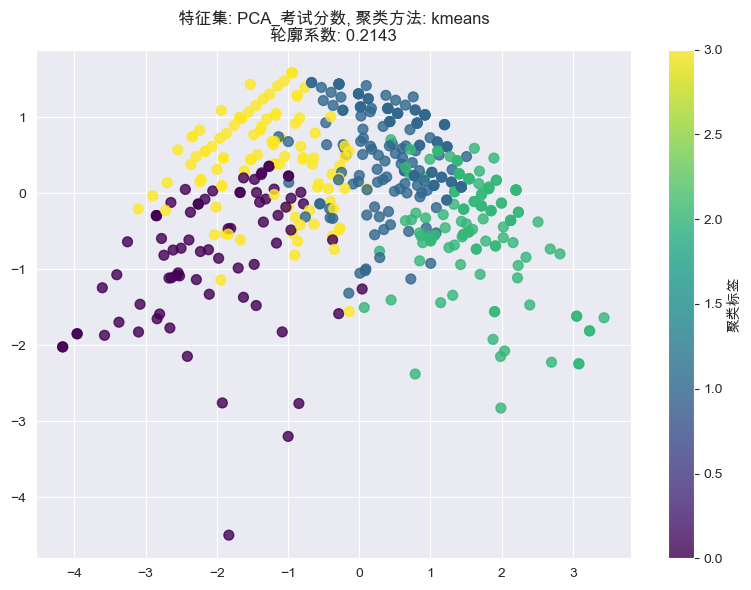


特征集: PCA_考试分数, 聚类方法: kmeans
调整兰德指数(ARI): 0.0782
归一化互信息(NMI): 0.0822
混淆矩阵:
[[ 9 70 88 22]
 [23 28  9 28]
 [ 5 10  8  3]
 [39 53 23 48]]


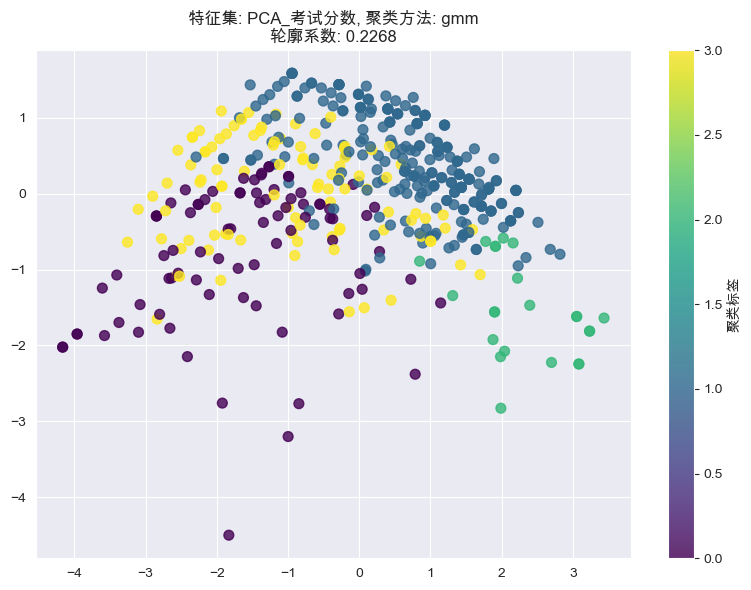


特征集: PCA_考试分数, 聚类方法: gmm
调整兰德指数(ARI): 0.0791
归一化互信息(NMI): 0.0578
混淆矩阵:
[[ 12 139  13  25]
 [ 22  38   3  25]
 [  7  13   3   3]
 [ 42  72   4  45]]


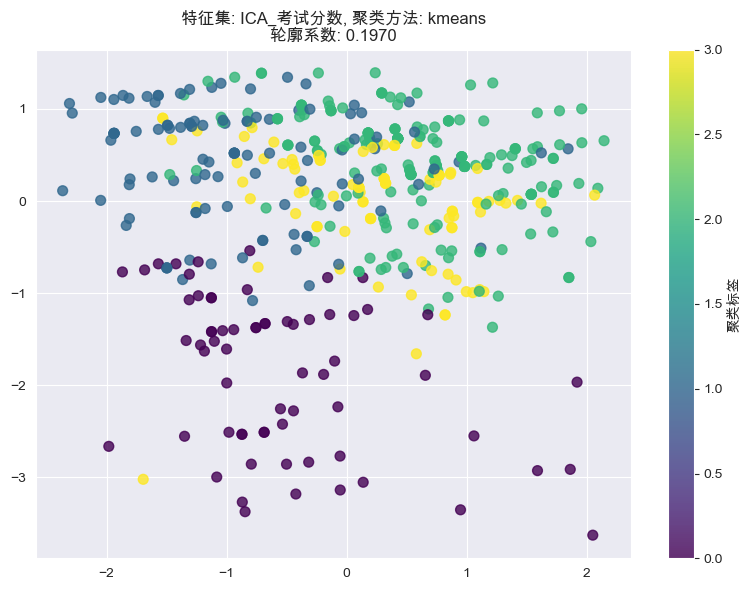


特征集: ICA_考试分数, 聚类方法: kmeans
调整兰德指数(ARI): 0.0583
归一化互信息(NMI): 0.0679
混淆矩阵:
[[  8  25 100  56]
 [ 15  30  31  12]
 [  5   1  13   7]
 [ 38  53  53  19]]


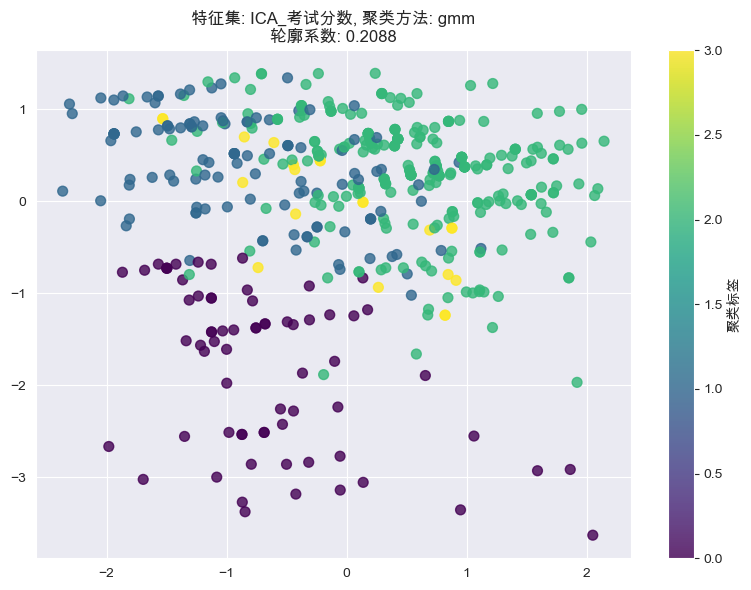


特征集: ICA_考试分数, 聚类方法: gmm
调整兰德指数(ARI): 0.0744
归一化互信息(NMI): 0.0637
混淆矩阵:
[[ 10  30 138  11]
 [ 19  25  41   3]
 [  5   1  17   3]
 [ 35  59  65   4]]


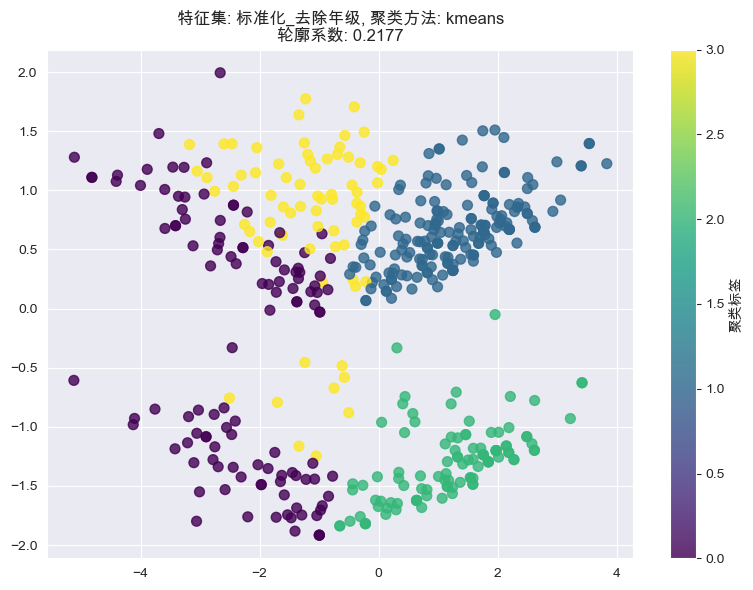


特征集: 标准化_去除年级, 聚类方法: kmeans
调整兰德指数(ARI): 0.1061
归一化互信息(NMI): 0.0908
混淆矩阵:
[[ 16 111  44  18]
 [ 34  24   8  22]
 [  4   4  14   4]
 [ 61  37  38  27]]


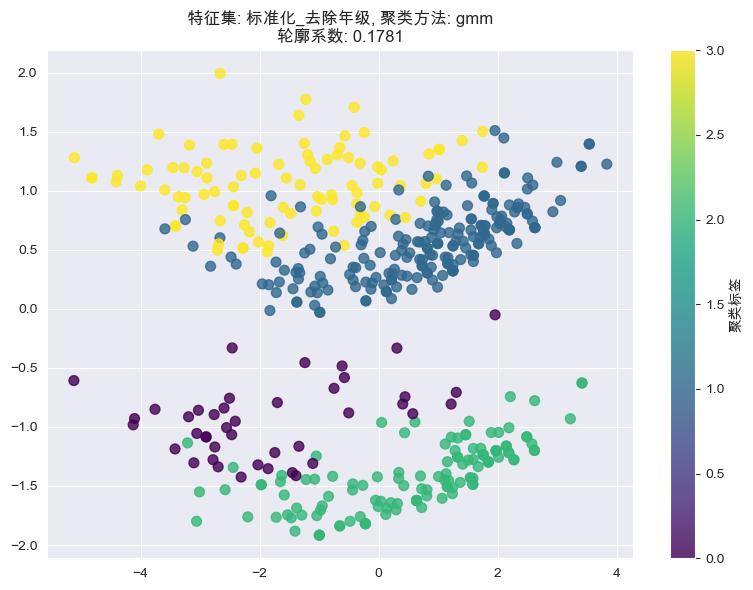


特征集: 标准化_去除年级, 聚类方法: gmm
调整兰德指数(ARI): 0.0623
归一化互信息(NMI): 0.0632
混淆矩阵:
[[  3 113  47  26]
 [  9  37  13  29]
 [  3   5  15   3]
 [ 27  51  50  35]]


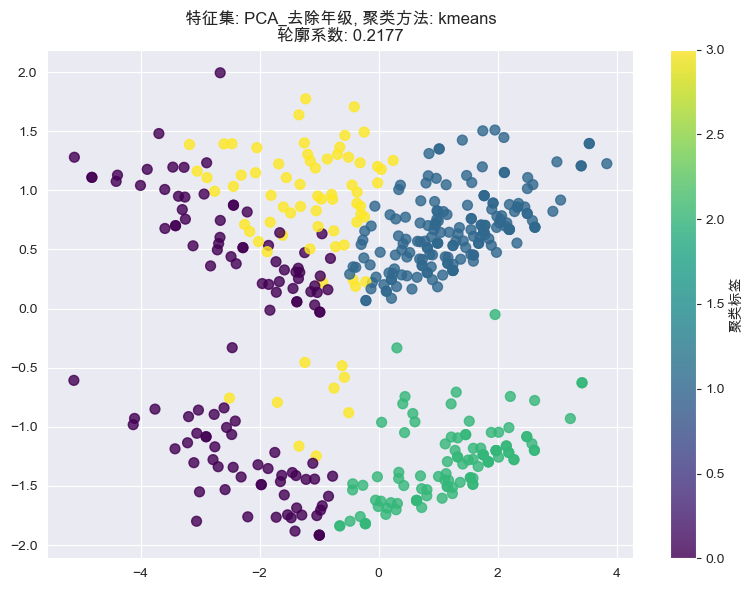


特征集: PCA_去除年级, 聚类方法: kmeans
调整兰德指数(ARI): 0.1061
归一化互信息(NMI): 0.0908
混淆矩阵:
[[ 16 111  44  18]
 [ 34  24   8  22]
 [  4   4  14   4]
 [ 61  37  38  27]]


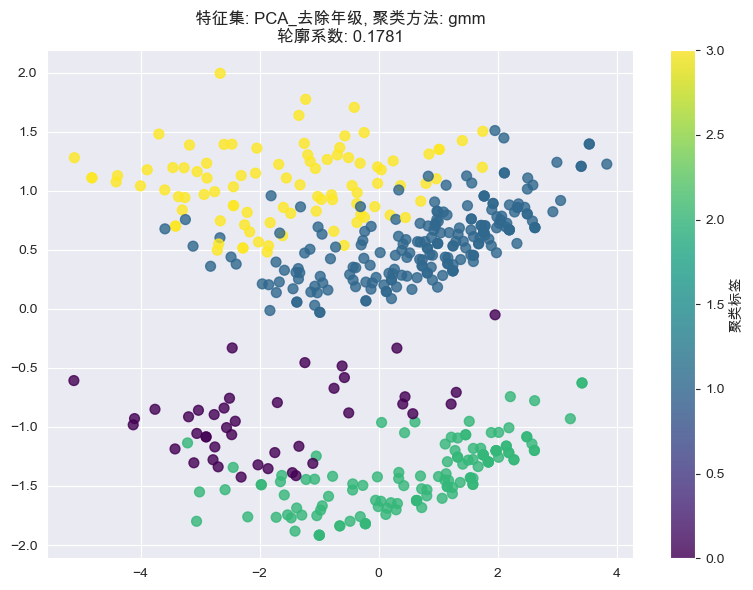


特征集: PCA_去除年级, 聚类方法: gmm
调整兰德指数(ARI): 0.0623
归一化互信息(NMI): 0.0632
混淆矩阵:
[[  3 113  47  26]
 [  9  37  13  29]
 [  3   5  15   3]
 [ 27  51  50  35]]


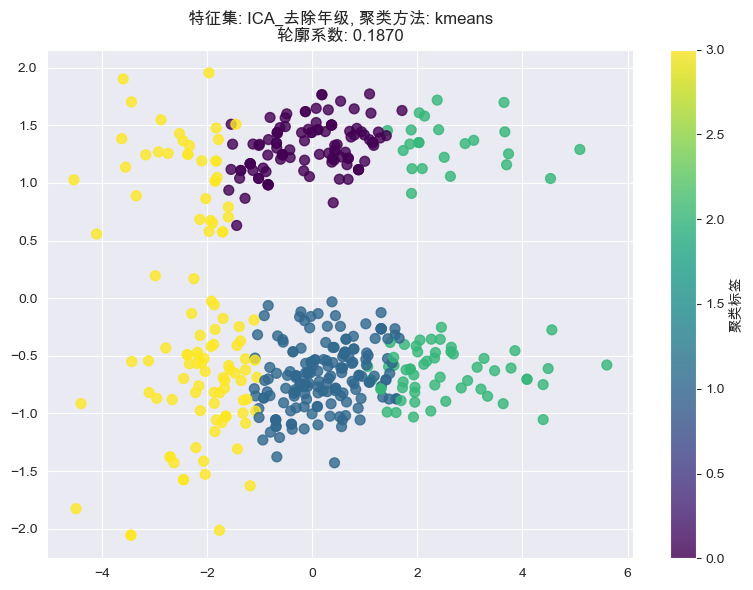


特征集: ICA_去除年级, 聚类方法: kmeans
调整兰德指数(ARI): 0.0451
归一化互信息(NMI): 0.0359
混淆矩阵:
[[37 97 19 36]
 [14 30 19 25]
 [ 9  4  4  9]
 [47 40 38 38]]


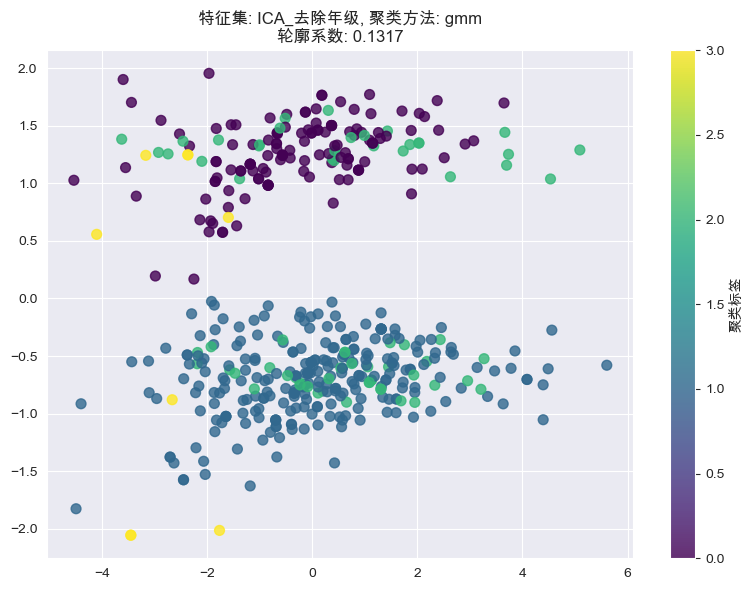


特征集: ICA_去除年级, 聚类方法: gmm
调整兰德指数(ARI): 0.0798
归一化互信息(NMI): 0.0826
混淆矩阵:
[[ 48 135   5   1]
 [ 15  52  18   3]
 [ 17   5   3   1]
 [ 52  64  43   4]]


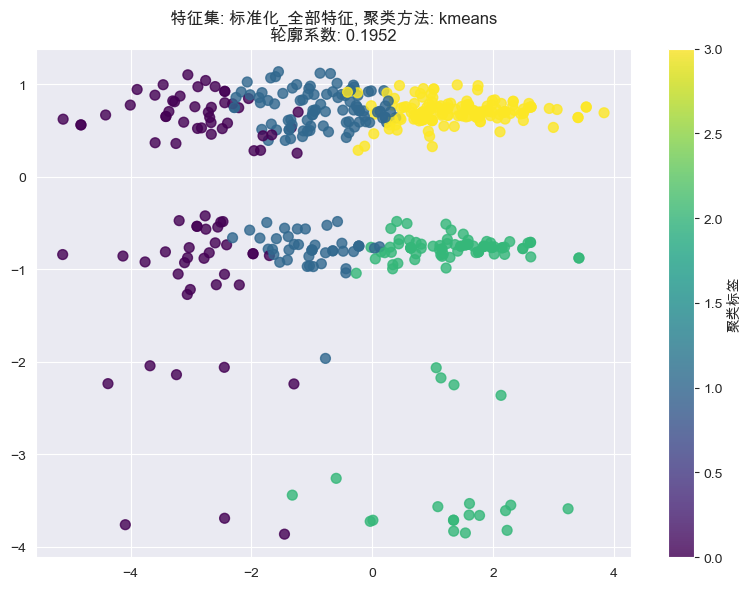


特征集: 标准化_全部特征, 聚类方法: kmeans
调整兰德指数(ARI): 0.1019
归一化互信息(NMI): 0.1274
混淆矩阵:
[[  5  42  41 101]
 [ 27  34   7  20]
 [  5   1  20   0]
 [ 43  58  31  31]]


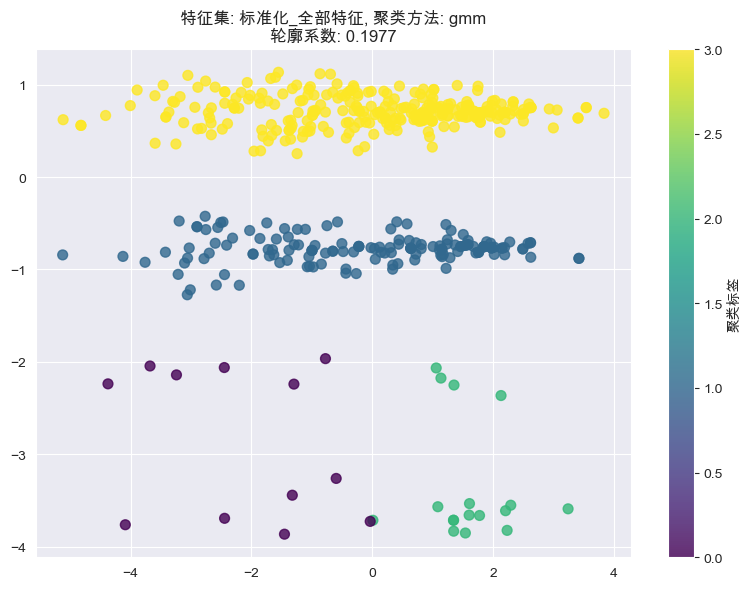


特征集: 标准化_全部特征, 聚类方法: gmm
调整兰德指数(ARI): 0.0976
归一化互信息(NMI): 0.2149
混淆矩阵:
[[  1  50   0 138]
 [  1  21   0  66]
 [  9   0  17   0]
 [  1  77   0  85]]


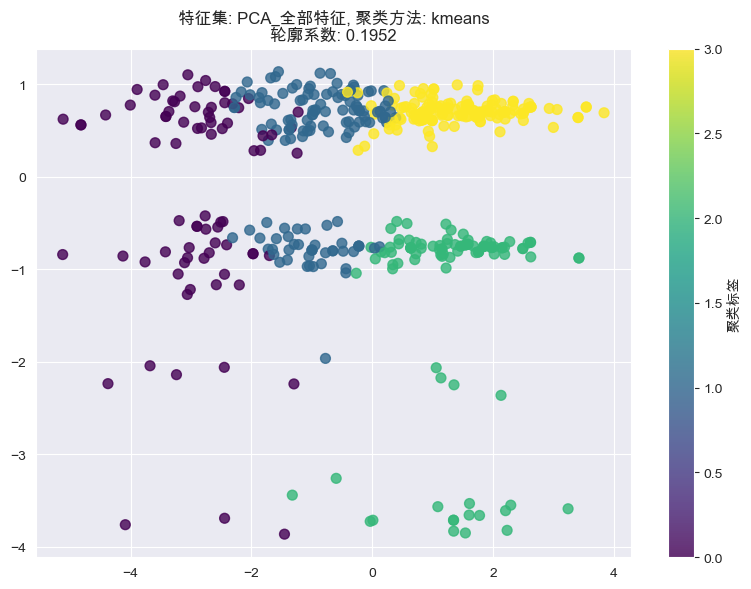


特征集: PCA_全部特征, 聚类方法: kmeans
调整兰德指数(ARI): 0.1019
归一化互信息(NMI): 0.1274
混淆矩阵:
[[  5  42  41 101]
 [ 27  34   7  20]
 [  5   1  20   0]
 [ 43  58  31  31]]


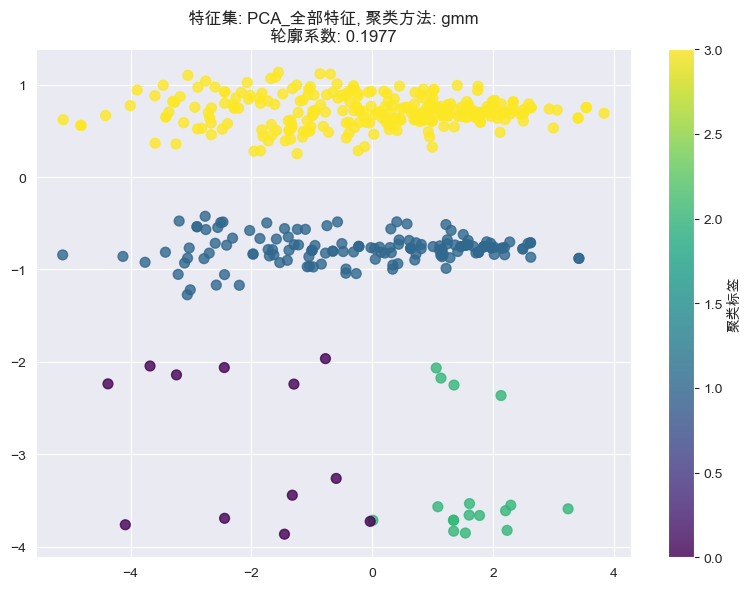


特征集: PCA_全部特征, 聚类方法: gmm
调整兰德指数(ARI): 0.0976
归一化互信息(NMI): 0.2149
混淆矩阵:
[[  1  50   0 138]
 [  1  21   0  66]
 [  9   0  17   0]
 [  1  77   0  85]]


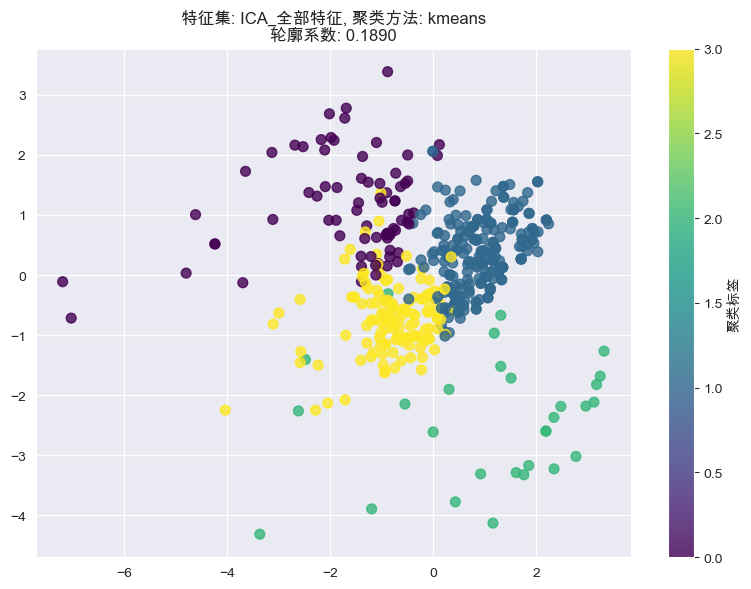


特征集: ICA_全部特征, 聚类方法: kmeans
调整兰德指数(ARI): 0.2010
归一化互信息(NMI): 0.2496
混淆矩阵:
[[ 11 146   1  31]
 [ 18  27   1  42]
 [  0   0  26   0]
 [ 45  54   1  63]]


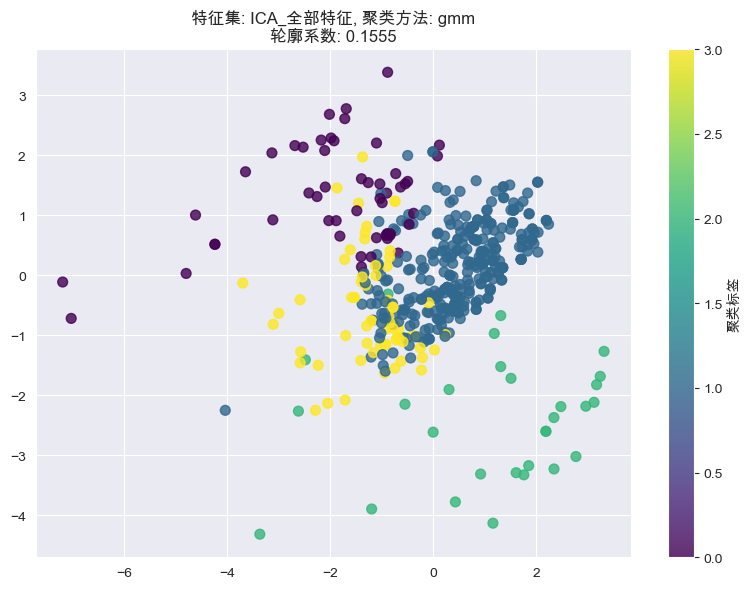


特征集: ICA_全部特征, 聚类方法: gmm
调整兰德指数(ARI): 0.1660
归一化互信息(NMI): 0.2433
混淆矩阵:
[[ 10 171   1   7]
 [ 16  54   1  17]
 [  0   0  26   0]
 [ 26  93   1  43]]

聚类结果表:
         特征集    聚类方法      轮廓系数  Davies-Bouldin  Calinski-Harabasz  聚类数  \
0   标准化_考试分数  kmeans  0.214335        1.495754         162.311073  4.0   
1   标准化_考试分数     gmm  0.226803        1.330118         116.583988  NaN   
2   PCA_考试分数  kmeans  0.214335        1.495754         162.311073  4.0   
3   PCA_考试分数     gmm  0.226803        1.330118         116.583988  NaN   
4   ICA_考试分数  kmeans  0.196993        1.536039          92.468940  4.0   
5   ICA_考试分数     gmm  0.208816        1.504724          82.200266  NaN   
6   标准化_去除年级  kmeans  0.217707        1.732314         142.907579  4.0   
7   标准化_去除年级     gmm  0.178135        1.908969          84.510548  NaN   
8   PCA_去除年级  kmeans  0.217707        1.732314         142.907579  4.0   
9   PCA_去除年级     gmm  0.178135        1.908969          84.510548  NaN   
10  ICA_去除年级  kmeans  0.18704

In [92]:
import warnings
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings('ignore')

# 真实标签编码，只需一次
y_true = LabelEncoder().fit_transform(df['Programme'])

# 结果表格
results_table = []

for feature_name, methods in best_results.items():
    for method_name, result in methods.items():
        # 记录聚类评估指标
        row = {
            '特征集': feature_name,
            '聚类方法': method_name,
            '轮廓系数': result['silhouette_score'],
            'Davies-Bouldin': result['davies_bouldin_score'],
            'Calinski-Harabasz': result['calinski_harabasz_score']
        }
        if method_name == 'kmeans':
            row['聚类数'] = result['n_clusters']
            row['初始化方法'] = result['init']
        elif method_name == 'gmm':
            row['组件数'] = result['n_components']
            row['协方差类型'] = result['covariance_type']
        elif method_name == 'hierarchical':
            row['聚类数'] = result['n_clusters']
            row['链接方法'] = result['linkage']
        results_table.append(row)

        # 可视化
        X_plot = feature_sets[feature_name]
        if X_plot.shape[1] > 2:
            X_vis = PCA(n_components=2).fit_transform(X_plot)
        else:
            X_vis = X_plot
        plt.figure(figsize=(8, 6))
        plt.scatter(X_vis[:, 0], X_vis[:, 1], c=result['labels'], cmap='viridis', alpha=0.8, s=50)
        plt.title(f'特征集: {feature_name}, 聚类方法: {method_name}\n轮廓系数: {result["silhouette_score"]:.4f}')
        plt.colorbar(label='聚类标签')
        plt.tight_layout()
        plt.show()

        # 聚类与真实标签对比
        labels = result['labels']
        ari = adjusted_rand_score(y_true, labels)
        nmi = normalized_mutual_info_score(y_true, labels)
        print(f"\n特征集: {feature_name}, 聚类方法: {method_name}")
        print(f"调整兰德指数(ARI): {ari:.4f}")
        print(f"归一化互信息(NMI): {nmi:.4f}")
        print("混淆矩阵:")
        print(confusion_matrix(y_true, labels))

# 结果表格展示
results_df = pd.DataFrame(results_table)
print("\n聚类结果表:")
print(results_df)

In [93]:
# 导入必要的库
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from evaluate import evaluate_clustering, evaluate_classification

# 1. 读取测试数据
test_df = pd.read_csv('test_data.csv')  # 替换为老师提供的测试文件名
print(f"测试数据形状: {test_df.shape}")
print(test_df.head())

# 2. 找到 ARI 最高的聚类结果
best_ari = -1
best_model = None
best_feature_name = None
best_method_name = None

for feature_name, methods in best_results.items():
    for method_name, result in methods.items():
        ari = adjusted_rand_score(y_true, result['labels'])
        if ari > best_ari:
            best_ari = ari
            best_model = result['model']
            best_feature_name = feature_name
            best_method_name = method_name

print(f"最佳模型: {best_feature_name}_{best_method_name}, ARI={best_ari:.4f}")

# 3. 手动处理测试数据，确保维度一致
# 获取训练特征的维度
train_features_shape = None
for name, features in feature_sets.items():
    if name == best_feature_name:
        train_features_shape = features.shape[1]
        break

print(f"训练特征维度: {train_features_shape}")

# 根据最佳特征集名称提取测试特征
if '考试分数' in best_feature_name:
    # 提取考试分数列
    if any('Q' in col for col in test_df.columns):
        exam_cols = [col for col in test_df.columns if 'Q' in col]
        X_test = test_df[exam_cols].values
    else:
        # 尝试使用最后几列
        X_test = test_df.select_dtypes(include=['float64', 'int64']).iloc[:, -train_features_shape:].values
elif '去除年级' in best_feature_name:
    # 提取基本信息
    basic_patterns = ['性别', 'Gender', 'sex', '项目', 'Total', '总分', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5']
    basic_cols = []
    for pat in basic_patterns:
        basic_cols += [col for col in test_df.columns if pat.lower() in col.lower()]
    basic_cols = list(dict.fromkeys(basic_cols))  # 去重

    # 如果找到的列不够，使用前几列
    if len(basic_cols) < train_features_shape:
        num_cols = test_df.select_dtypes(include=['float64', 'int64']).columns[:train_features_shape]
        X_test = test_df[num_cols].values
    else:
        # 如果找到的列太多，只取需要的列数
        X_test = test_df[basic_cols[:train_features_shape]].values
else:  # '全部特征'
    # 排除programme列
    num_df = test_df.select_dtypes(include=['float64', 'int64'])
    programme_cols = [col for col in num_df.columns if 'programme' in col.lower() or 'program' in col.lower()]
    if programme_cols:
        X_test_all = num_df.drop(columns=programme_cols).values
    else:
        X_test_all = num_df.values

    # 确保维度匹配
    if X_test_all.shape[1] > train_features_shape:
        X_test = X_test_all[:, :train_features_shape]  # 截断多余的列
    elif X_test_all.shape[1] < train_features_shape:
        # 如果列数不足，填充零
        padding = np.zeros((X_test_all.shape[0], train_features_shape - X_test_all.shape[1]))
        X_test = np.hstack((X_test_all, padding))
        print(f"警告: 测试数据特征不足，已用零填充至{train_features_shape}列")
    else:
        X_test = X_test_all

# 确保维度一致
if X_test.shape[1] != train_features_shape:
    if X_test.shape[1] > train_features_shape:
        X_test = X_test[:, :train_features_shape]  # 截断
    else:
        # 填充零列
        padding = np.zeros((X_test.shape[0], train_features_shape - X_test.shape[1]))
        X_test = np.hstack((X_test, padding))

print(f"调整后测试特征维度: {X_test.shape}")

# 4. 应用与训练数据相同的标准化
scaler = StandardScaler()
scaler.fit(feature_sets[best_feature_name])  # 用训练数据拟合
X_test_scaled = scaler.transform(X_test)  # 转换测试数据
from sklearn.metrics import f1_score, accuracy_score
from scipy.optimize import linear_sum_assignment

def compute_metrics(y_true, y_pred):
    """
    计算聚类结果的F1分数和准确率，通过匈牙利算法将聚类标签映射到真实标签

    参数:
    y_true - 真实标签
    y_pred - 聚类预测标签

    返回:
    accuracy - 准确率
    f1 - F1分数
    label_mapping - 标签映射关系
    """
    # 构建混淆矩阵
    cm = confusion_matrix(y_true, y_pred)

    # 使用匈牙利算法找到最佳的标签映射
    row_ind, col_ind = linear_sum_assignment(-cm)

    # 创建映射字典
    label_mapping = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}

    # 应用映射
    y_pred_mapped = np.array([label_mapping.get(label, label) for label in y_pred])

    # 计算准确率和F1分数
    accuracy = accuracy_score(y_true, y_pred_mapped)
    f1 = f1_score(y_true, y_pred_mapped, average='weighted')

    return accuracy, f1, label_mapping

# 在测试代码的第5步后添加以下代码
# 5. 使用最佳模型预测
test_labels = best_model.predict(X_test_scaled)
print(f"测试数据聚类完成，标签分布: {np.unique(test_labels, return_counts=True)}")

# 计算F1分数和准确率
if 'Programme' in test_df.columns:
    # 如果测试数据有真实标签
    test_true_labels = LabelEncoder().fit_transform(test_df['Programme'])
    accuracy, f1, mapping = compute_metrics(test_true_labels, test_labels)
    print(f"聚类结果评估 - 准确率: {accuracy:.4f}, F1分数: {f1:.4f}")
    print(f"聚类标签映射: {mapping}")

# 6. 保存聚类结果
output_file = f'clustering_{best_feature_name}_{best_method_name}_test.csv'
ratio = evaluate_clustering(X_test_scaled, test_labels, output_file=output_file)
print(f"聚类结果已保存到 {output_file}")

测试数据形状: (619, 11)
   Index  Gender  Programme  Grade  Total  MCQ  Q1  Q2  Q3    Q4  Q5
0      1       1          3      3   45.0   21   8   4   2  10.0   0
1      2       2          3      3   43.0   21   4   2   8   8.0   0
2      3       1          4      2   26.0   24   0   0   2   0.0   0
3      4       2          1      3   30.0   24   4   0   0   0.0   2
4      5       1          2      3   27.0   21   0   2   4   0.0   0
最佳模型: ICA_全部特征_kmeans, ARI=0.2010
训练特征维度: 8
调整后测试特征维度: (619, 8)
测试数据聚类完成，标签分布: (array([1, 2], dtype=int32), array([ 57, 562]))
聚类结果评估 - 准确率: 0.4475, F1分数: 0.3296
聚类标签映射: {np.int64(2): np.int64(0), np.int64(3): np.int64(1), np.int64(0): np.int64(2), np.int64(1): np.int64(3)}
File saved successfully in clustering_ICA_全部特征_kmeans_test.csv
Intra-cluster to Inter-cluster distance ratio: 0.5842
聚类结果已保存到 clustering_ICA_全部特征_kmeans_test.csv
